# DSCI-552 Homework 1: Vertebral Column Data Set

Name: Ruihao Wang $\quad$ USC ID: 9867439484

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

## 1. (a) Download the Vertebral Column Data Set from

In [2]:
# Paths of two dataset labled with different labels
NA_PATH = "../data/vertebral_column_data/column_2C.dat"
NDS_PATH = "../data/vertebral_column_data/column_3C.dat"

# name of columns (6 features + 1 label = 7 columns)
NAMES = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", 
         "sacral_slope", "pelvic_radius", "grade_of_spondylolisthesis", "label"]

# read the binray classified dataset
na_df = pd.read_csv(NA_PATH, header=None, sep="\s+", names=NAMES)
na_df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,label
0,63.03,22.55,39.61,40.48,98.67,-0.25,AB
1,39.06,10.06,25.02,29.00,114.41,4.56,AB
2,68.83,22.22,50.09,46.61,105.99,-3.53,AB
3,69.30,24.65,44.31,44.64,101.87,11.21,AB
4,49.71,9.65,28.32,40.06,108.17,7.92,AB
...,...,...,...,...,...,...,...
305,47.90,13.62,36.00,34.29,117.45,-4.25,NO
306,53.94,20.72,29.22,33.22,114.37,-0.42,NO
307,61.45,22.69,46.17,38.75,125.67,-2.71,NO
308,45.25,8.69,41.58,36.56,118.55,0.21,NO


## 1. (b) Pre-processing and Exploratory data analysis

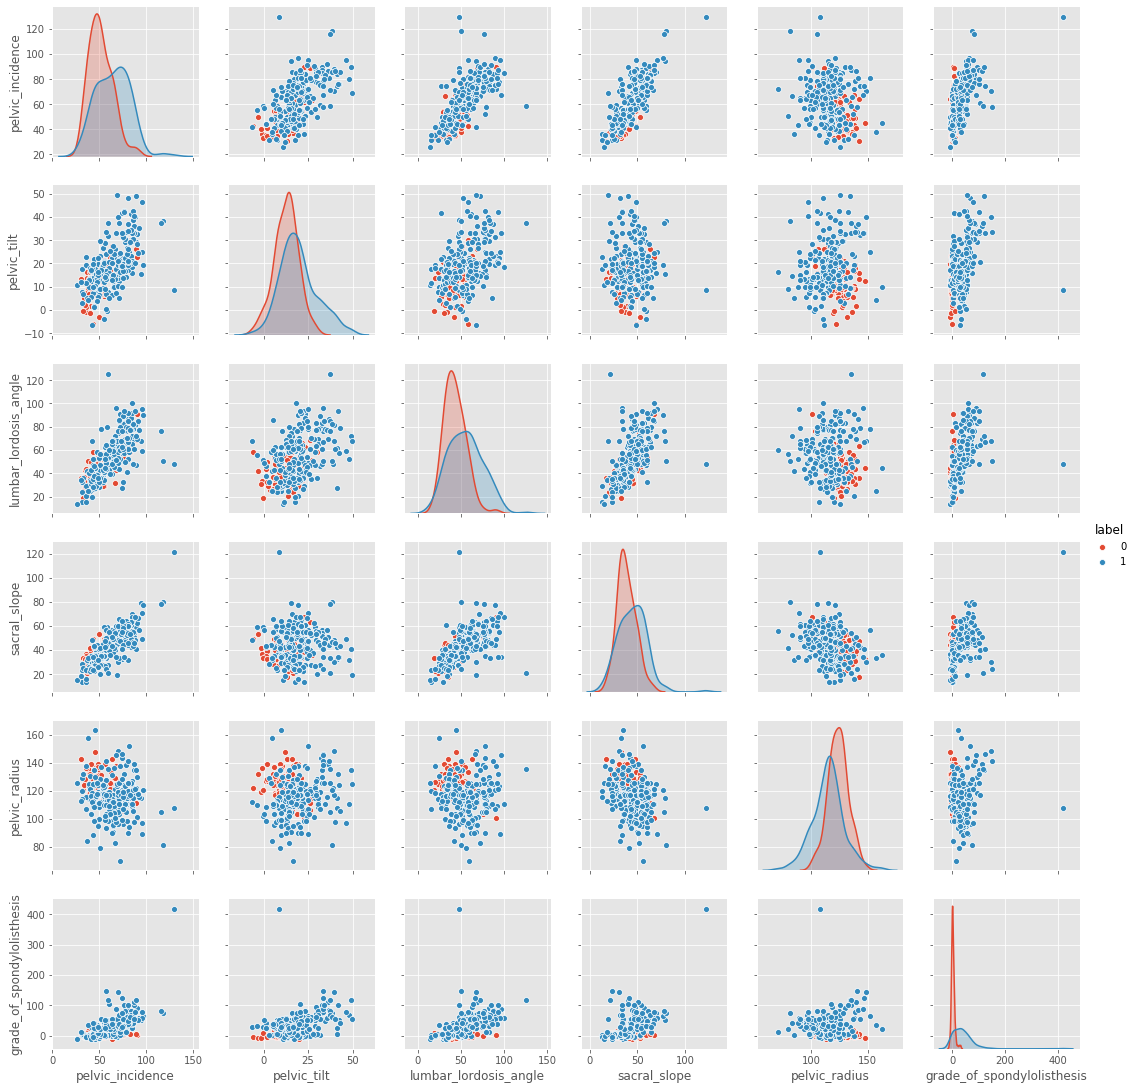

In [3]:
# 1.(b)i Make scatterplots of the independent variables in the dataset.
# relative doc: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# redefine label to 0 (NO) and 1 (AB)
na_df.loc[na_df["label"] == "NO", "label"] = 0
na_df.loc[na_df["label"] == "AB", "label"] = 1

# create scatter plot
pair_plot = sns.pairplot(na_df, hue="label", diag_kind="kde")

plt.show()

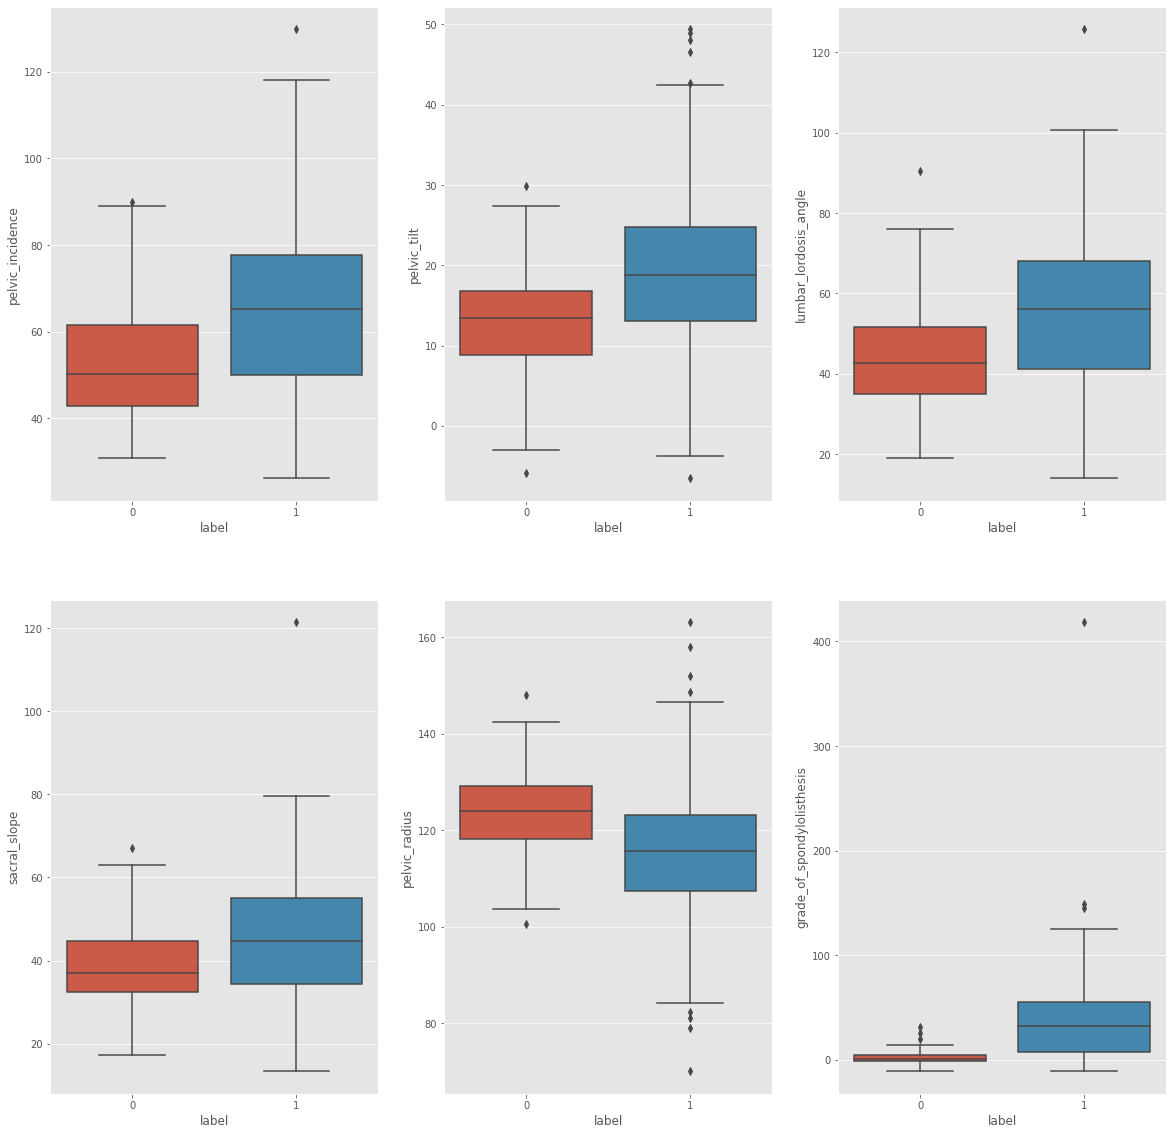

In [4]:
# 1.(b)ii make box plots for each of the independent variables
# relative doc:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot
# https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html

fig, axes = plt.subplots(2, 3, figsize=(20, 20))

for i in range(6):
    sns.boxplot(x="label", y=NAMES[i], data=na_df, ax=axes[i // 3, i % 3])

plt.show()

In [5]:
# 1.(b)iii select first 70 of calss 0 and first 140 class 1 as training set
# relative docs:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html

train_set = pd.concat([na_df[na_df["label"] == 0].iloc[0:70, :],
                          na_df[na_df["label"] == 1].iloc[0:140, :]],
                          ignore_index=True)

test_set = pd.concat([na_df[na_df["label"] == 0].iloc[70:, :],
                          na_df[na_df["label"] == 1].iloc[140:, :]],
                          ignore_index=True)

print("The training set has shape ", train_set.shape)
print("The test set has shape ", test_set.shape)

train_set

The training set has shape  (210, 7)
The test set has shape  (100, 7)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,grade_of_spondylolisthesis,label
0,38.51,16.96,35.11,21.54,127.63,7.99,0
1,54.92,18.97,51.60,35.95,125.85,2.00,0
2,44.36,8.95,46.90,35.42,129.22,4.99,0
3,48.32,17.45,48.00,30.87,128.98,-0.91,0
4,45.70,10.66,42.58,35.04,130.18,-3.39,0
...,...,...,...,...,...,...,...
205,77.12,30.35,77.48,46.77,110.61,82.09,1
206,88.02,39.84,81.77,48.18,116.60,56.77,1
207,83.40,34.31,78.42,49.09,110.47,49.67,1
208,72.05,24.70,79.87,47.35,107.17,56.43,1


## 1.(c) Classification using KNN on Vertebral Column Data Set

### 1.(c)i Write code for k-nearest neighbors with Euclidean metric cont'd

In [6]:
# 1.(c)i Write code for k-nearest neighbors with Euclidean metric
from heapq import heappop, heappush
from sklearn.metrics import confusion_matrix

class KNNClassifier:
    
    def __init__(self, K=6, metric='euclidean', p=2, weighted=False):
        '''
        K : int, the number of K neighbors to poll
        metric : string, type of distance as metric
        p : int, the order of norm
        weighted : bool, in weighted mode or not
        '''
        self.K = K
        self.metric = metric
        self.weighted = weighted
        self.p = p
    
    def euclidean_dist(self, u, v):
        u = u.to_numpy()
        v = v.to_numpy()
        return np.linalg.norm(u - v)
    
    def minkowski_dist(self, u, v, p):
        u = u.to_numpy()
        v = v.to_numpy()
        return np.linalg.norm(u - v, ord=p)
    
    def chebyshev_dist(self, u, v):
        u = u.to_numpy()
        v = v.to_numpy()
        return np.max(np.abs(u - v))

    def mahalanobis_dist(self, u, v, covI):
        u = u.to_numpy()
        v = v.to_numpy()
        delta = u - v
        #m = np.dot(np.dot(delta, covI), delta.T)
        m = delta@covI@delta.T
        return np.sqrt(m);
        
    def fit(self, trainX, trainY, testX, testY):
        '''
        trainX: dataframe, training sample features
        trainY : data_frame, training sample labels
        testX: dataframe, test sample features
        testY : data_frame, test sample labels
        
        return: a dictionary contains results and paramters of model
        '''
        
        predictions = []
        
        # calculate the covariance matrix if using Mahalanobisa as metric
        if self.metric == 'mahalanobis':
            covI = np.linalg.inv(trainX.cov())
        
        for i in range(testX.shape[0]):
            # create a list as the container of a max heap with size K
            max_heap = []
            u = testX.iloc[i]
            for j in range(trainX.shape[0]):
                v = trainX.iloc[j]
                if self.metric == 'manhattan':
                    dist = self.minkowski_dist(u, v, 1)
                elif self.metric == 'minkowski':
                    dist = self.minkowski_dist(u, v, self.p)
                elif self.metric == 'chebyshev':
                    dist = self.chebyshev_dist(u, v)
                elif self.metric == 'mahalanobis':
                    dist = self.mahalanobis_dist(u, v, covI)
                else:
                    # dist = self.euclidean_dist(u, v)
                    dist = self.minkowski_dist(u, v, 2)
                heappush(max_heap, (-dist, j))
                if len(max_heap) > self.K:
                    heappop(max_heap)
            
            # majority polling
            vote = 0
            while len(max_heap) > 0:
                dist, idx = heappop(max_heap)
                # non-weighted poll
                if not self.weighted:
                    vote += 1 if trainY[idx] == 0 else -1
                # weighted poll
                else:
                    vote += (1 / -dist) if trainY[idx] == 0 else (1 / dist)
            
            predictions.append(0 if vote >= 0 else 1)
        
        # error rate calculation, note that convert Series to list
        error_rate = (predictions != testY.values).sum() / len(testY)
        
        # confusion matrix, note that the datatype of two vector MUST be the same
        confusion_mat = confusion_matrix(testY.to_numpy('int64'), np.array(predictions))
        
        return {
            'error_rate' : error_rate,
            'confusion_mat' : confusion_mat,
            'k' : self.K,
            'metric' : self.metric,
            'weighted' : self.weighted
        }

In [7]:
# dsplit features and labels
trainX = train_set.iloc[:, :-1]
trainY = train_set.iloc[:, -1]
testX = test_set.iloc[:, :-1]
testY = test_set.iloc[:, -1]

### 1.(c)i Write code for k-nearest neighbors with Euclidean metric cont'd

In [8]:
# 1.(c)i Write code for k-nearest neighbors with Euclidean metric cont'd
# create a KNN classifier with default settings to test
clf = KNNClassifier()
result_params = clf.fit(trainX, trainY, testX, testY)
result_params

{'error_rate': 0.08,
 'confusion_mat': array([[22,  8],
        [ 0, 70]]),
 'k': 6,
 'metric': 'euclidean',
 'weighted': False}

### 1.(c)ii Vary the value of K and find the K* with best performance

The decrement step of $k$ is -1. The model fitting here will take a long time as my simple brute-force implementation using heap to keep the nearest neighbors rather than using kd-tree which is the KNN solution in sklearn package.

In [9]:
# 1.(c)ii Vary the value of K and the K* with best performance
best = {
    'error_rate' : float('inf'),
    'confusion_mat' : None,
    'k' : 0,
    'metric' : "",
    'weighted' : False
}

k_step = -1
k_values = range(208, 0, k_step)
train_errors, test_errors = [], []

# iterate k from 208 (inclusive) to 0 (exclusive) with set step
for k in k_values:
    clf = KNNClassifier(K=k)
    
    train_result = clf.fit(trainX, trainY, trainX, trainY)
    train_errors.append(train_result['error_rate'])
    
    test_result = clf.fit(trainX, trainY, testX, testY)
    if (test_result['error_rate'] < best['error_rate']):
        best = test_result
    test_errors.append(test_result['error_rate'])

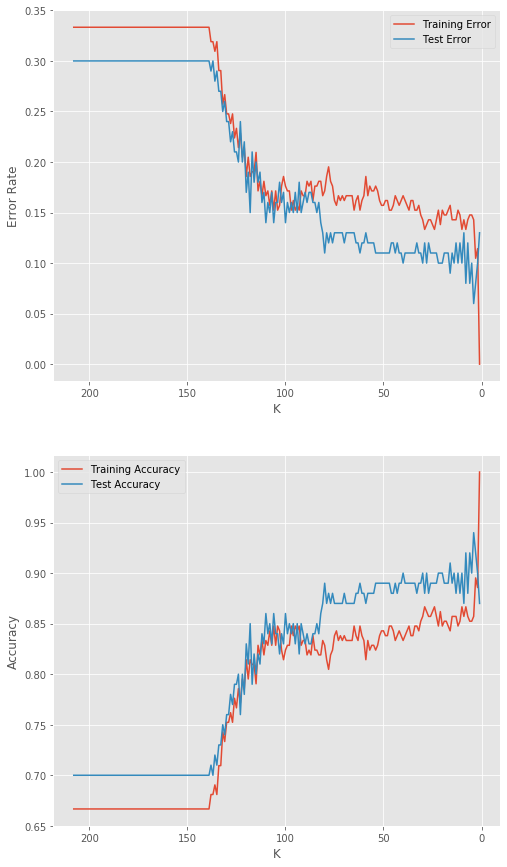

In [10]:
# plot curve of error/accuracy rate versus k
fig, axes = plt.subplots(2, 1, figsize=(8, 15))

# error curve
axes[0].plot(k_values, train_errors, label="Training Error")
axes[0].plot(k_values, test_errors, label="Test Error")
axes[0].invert_xaxis()
axes[0].set_xlabel("K")
axes[0].set_ylabel("Error Rate")
axes[0].legend()

# accuracy curve
axes[1].plot(k_values, list(map((lambda x: 1 - x), train_errors)), label="Training Accuracy")
axes[1].plot(k_values, list(map((lambda x: 1 - x), test_errors)), label="Test Accuracy")
axes[1].invert_xaxis()
axes[1].set_xlabel("K")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.show()

From figures above, we can see that the performance getting better as the value of $k$ going down. When $k=1$, we can see a perfect accuracy on training set but the performance on test set get degraded. The lowest point of test error occurs **around** $k=5$. The following block will goes further to see the value of k.

{'confusion_mat': array([[25,  5],
       [ 1, 69]]),
 'error_rate': 0.06,
 'k': 4,
 'metric': 'euclidean',
 'weighted': False}


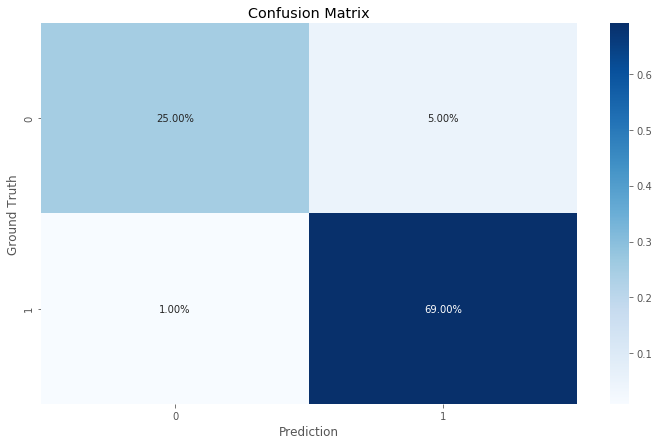


--------------------------------------------------
Performance Report
--------------------------------------------------
True Positive:  25
False Positive: 1
True Negative:  69
False Negative:  5
--------------------------------------------------
True Positive Rate:  0.8333333333333334
True Negative Rate:  0.9857142857142858
--------------------------------------------------
Class 0
Precision:  0.9615384615384616
Recall:  0.8333333333333334
F1-score:  0.8928571428571429
--------------------------------------------------
Class 1
Precision:  0.9324324324324325
Recall:  0.9857142857142858
F1-score:  0.9583333333333333
--------------------------------------------------


In [11]:
# 1.(c)ii Vary the value of K and the K* with best performance
def model_evaluation(confusion):
    dash_len = 50
    total_num = np.sum(confusion)
    
    tp = confusion[0, 0]
    fp = confusion[1, 0]
    tn = confusion[1, 1]
    fn = confusion[0, 1]
    
    tp_rate =  tp / (tp + fn)
    tn_rate = tn / (fp + tn)
    
    precision_0 = tp / (tp + fp)
    recall_0 = tp / (tp + fn)
    f1_0 = 2 * (precision_0 * recall_0) / (precision_0 + recall_0)
    
    precision_1 = tn / (tn + fn)
    recall_1 = tn / (tn + fp)
    f1_1 = 2 * (precision_1 * recall_1) / (precision_1 + recall_1)
    
    print('\n'+'-' * dash_len)
    print("Performance Report")
    print('-' * dash_len)
    print('True Positive: ', tp)
    print('False Positive:', fp)
    print('True Negative: ', tn)
    print('False Negative: ', fn)
    print('-' * dash_len)
    print('True Positive Rate: ', tp_rate)
    print('True Negative Rate: ', tn_rate)
    print('-' * dash_len)
    print('Class 0')
    print('Precision: ', precision_0)
    print('Recall: ', recall_0)
    print('F1-score: ', f1_0)
    print('-' * dash_len)
    print('Class 1')
    print('Precision: ', precision_1)
    print('Recall: ', recall_1)
    print('F1-score: ', f1_1)
    print('-' * dash_len)
    

import pprint
pprint.pprint(best)

confus_mat = best['confusion_mat']

fig, axe = plt.subplots(1, 1, figsize=(12,7))
sns.heatmap((confus_mat / np.sum(confus_mat)), annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

model_evaluation(best['confusion_mat'])

The most suitable **$\mathbf{k = k^*}$ is 4**. The required values are output as in the "Performance Report".

### 1.(c)iii Plot learning curve with different traning size n

Large number of paramter iterations. It will take long time as well

In [12]:
# 1.(c)iii Plot learning curve with different traning size n
N_values = range(10, 211, 10)

best_Ks = []
best_Errors = []

for N in N_values:
    # truncate train set
    truncated_train_set = pd.concat([train_set[train_set["label"] == 0].iloc[0: N // 3, :], 
                                    train_set[train_set["label"] == 1].iloc[0: N - N // 3, :]],
                                    ignore_index=True)
    
    trainX = truncated_train_set.iloc[:, :-1]
    trainY = truncated_train_set.iloc[:, -1]
    
    best_error = float('inf')
    best_k = 0
    for k in range(1, N, 5):
        clf = KNNClassifier(K=k)
        
        result = clf.fit(trainX, trainY, testX, testY)
        if (result['error_rate'] < best_error):
            best_k = result['k']
            best_error = result['error_rate']
    
    best_Ks.append(best_k)
    best_Errors.append(best_error)

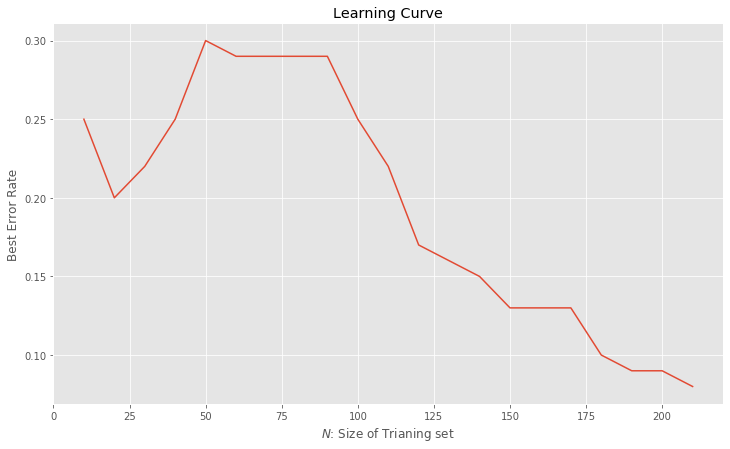

In [13]:
# plot the figure of Learning curve
fig, axes = plt.subplots(1, 1, figsize=(12, 7))
axes.plot(N_values, best_Errors)
axes.set_xlabel('$N$: Size of Trianing set')
axes.set_ylabel('Best Error Rate')
axes.set_title('Learning Curve')
plt.show()

## 1.(d) Summarize the test errors (i.e., k = k∗) with different metrics

In [14]:
# define a function to iterate models with various k values
def investigate_models(train_set, test_set, metric, k_values, weighted=False):
    # use the whole train set
    trainX = train_set.iloc[:, :-1]
    trainY = train_set.iloc[:, -1]
    
    # split features and labels in test set
    testX = test_set.iloc[:, :-1]
    testY = test_set.iloc[:, -1]
    
    error_vals = []
    best_options = []
    
    for k in k_values:
        clf = KNNClassifier(K=k, metric=metric, weighted=weighted)
        result = clf.fit(trainX, trainY, testX, testY)
        if (len(best_options) == 0 or result['error_rate'] <= best_options[-1]['error_rate']):
            if (len(best_options) != 0 and result['error_rate'] < best_options[-1]['error_rate']):
                best_options = []
            best_options.append(result)
        error_vals.append(result['error_rate'])
    
    return (error_vals, best_options)

# define a function to plot curve of error rate versus k
def plot_error_k(error_vals, k_values, best_options, metric):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.plot(k_values, error_vals, label='Error v.s. K')
    for best in best_options:
        axes.axhline(best['error_rate'], color='b', alpha=0.3, linestyle='--')
        axes.axvline(best['k'], color='b', alpha=0.3, linestyle='--')
        axes.plot(best['k'], best['error_rate'], '^',
                  label='({}, {})'.format(best['k'], best['error_rate']))
    axes.set_title('Error Rate using {} Distance with different K'.format(metric))
    axes.set_xlabel('K')
    axes.set_ylabel('Error Rate')
    axes.legend()
    plt.show()


### 1.(d) i.A - When $p = 1$, Minikowski Distance becomes Manhattan Distance

$$
Manhattan(u, v) = Minikowski(u, v, 1) = \sum_{i = 1}^{n}|u_i - v_i|
$$

In [15]:
# 1.(d) - iA: Manhattan Distance 
k_values = range(1, 200, 5)
manhat_error_vals, manhat_best_options = investigate_models(train_set, test_set, 'manhattan', k_values)

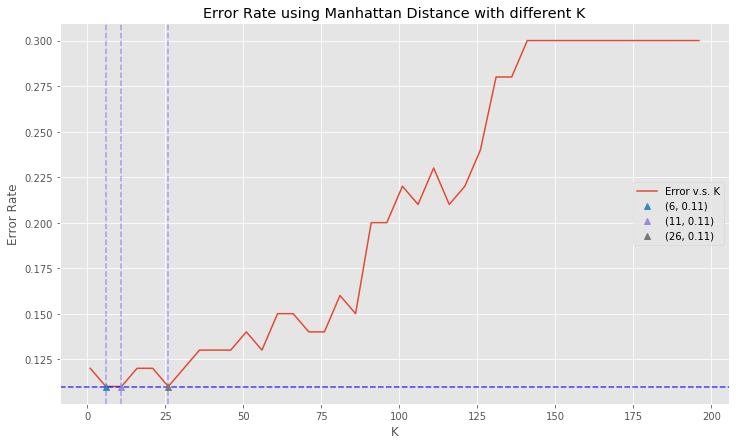

In [16]:
plot_error_k(manhat_error_vals, k_values, manhat_best_options, 'Manhattan')

From the figure above, we can see that **Manhattan Distance has the best performance when k is in \[6, 11, 26\]**.

### 1.(d) iB - Minikowski Distance with variying $p$ values of p

$$
log_{10}(p) \in \{0.1, 0.2, 0.3, ..., 1\} \Rightarrow p \in \{10^{0.1}, 10^{0.2}, ..., 10\} \\
Minikowski(u, v, p) = \left(\sum_{i = 1}^{n}|u_i - v_i|^p\right)^{\frac{1}{p}}
$$

In [37]:
# 1.(d) - iB: Minkowski Distance 
logp_values = np.linspace(0.1, 1, 10)
p_values = np.logspace(0.1, 1, 10)

# use the whole train set
trainX = train_set.iloc[:, :-1]
trainY = train_set.iloc[:, -1]

minik_error_vals = []
minik_best_options = []

for p in p_values:
    clf = KNNClassifier(K=6, metric='minkowski', p=p)
    result = clf.fit(trainX, trainY, testX, testY)
    if (len(minik_best_options) == 0 or result['error_rate'] <= minik_best_options[-1]['error_rate']):
        if (len(minik_best_options) != 0 and result['error_rate'] < minik_best_options[-1]['error_rate']):
            minik_best_options = []
        minik_best_options.append(result)
    minik_error_vals.append(result['error_rate'])

p_analysis = {
    'K' : [6 for i in range(len(p_values))],
    'p' : p_values,
    'log10(p)' : logp_values,
    'Error_Rate' : minik_error_vals
}

p_analysis = pd.DataFrame(p_analysis)
p_analysis

,K,p,log10(p),Error_Rate
0,6,1.258925,0.1,0.09
1,6,1.584893,0.2,0.09
2,6,1.995262,0.3,0.08
3,6,2.511886,0.4,0.08
4,6,3.162278,0.5,0.08
5,6,3.981072,0.6,0.06
6,6,5.011872,0.7,0.07
7,6,6.309573,0.8,0.08
8,6,7.943282,0.9,0.09
9,6,10.000000,1.0,0.09


In [18]:
best_ps = p_analysis.loc[p_analysis['Error_Rate'] == p_analysis['Error_Rate'].min(), ['p', 'log10(p)']]
best_ps

,p,log10(p)
5,3.981072,0.6


From the tables above, we can see that, with $k^* = 6$, $p = 3.981072$ gives the minimum error rate of 0.06.

### 1.(d) iC - Chebyshev Distance

When When $p \rightarrow \infty$, the maximum difference of one dimension in feature space will overwhelm the sum. Minikowski Distance becomes **Chebyshev Distance**

$$
Chebyshev(u, v) = \lim_{p \rightarrow \infty}Minikowski(u, v, p) = \max_{i \in \{1,..., n\}}|u_i - v_i|
$$

In [19]:
# 1.(d) - iC: Chebyshev Distance 
k_values = range(1, 200, 5)
cheby_error_vals, cheby_best_options = investigate_models(train_set, test_set, 'chebyshev', k_values)

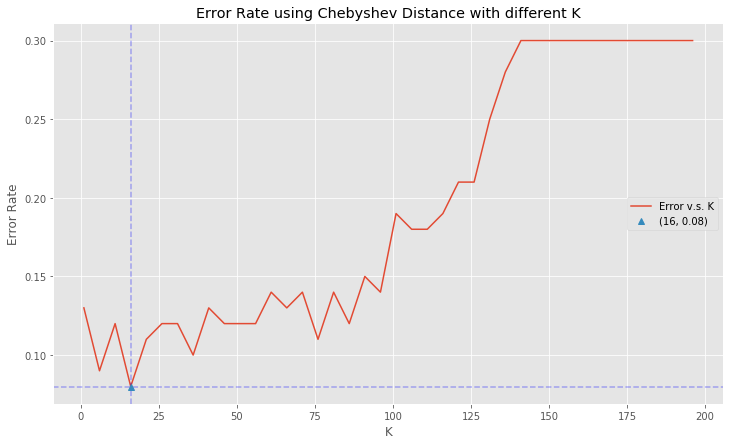

In [20]:
plot_error_k(cheby_error_vals, k_values, cheby_best_options, 'Chebyshev')

When using **Chebyshev Distance** as metric, the best performance of **0.08** error rate occurs at $k = 16$.

### 1.(e) ii Mahalanobis Distance

$$
Mahalanobis(u, v) = \sqrt{(u - v)V^{-1}(u - v)^T}
$$

where $V$ is the covariance matrix.

Implementation References:

- [Fomular Reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.mahalanobis.html)

- [numpy covariance](https://numpy.org/doc/stable/reference/generated/numpy.cov.html)

- [Mahalanobis Distance · Chris](https://mccormickml.com/2014/07/22/mahalanobis-distance/#:~:text=The%20general%20equation%20for%20the,covariances%20between%20the%20vector%20components.&text=With%20that%20in%20mind%2C%20below,S%20is%20the%20covariance%20matrix.)

In [21]:
# 1.(d) - ii: Mahalanobis Distance 
k_values = range(1, 200, 5)
mahal_error_vals, mahal_best_options = investigate_models(train_set, test_set, 'mahalanobis', k_values)

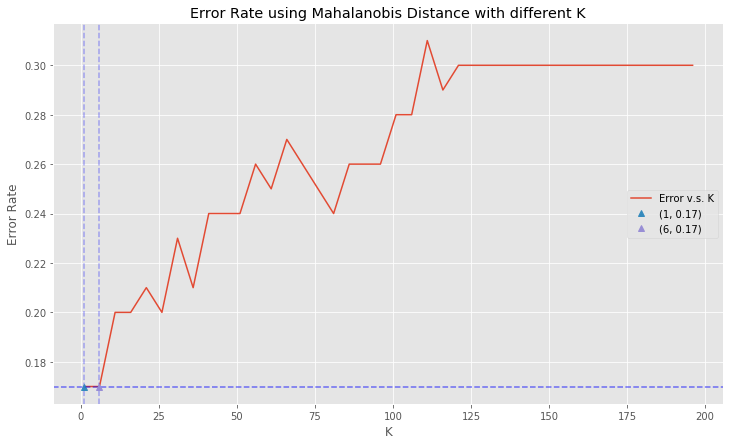

In [22]:
plot_error_k(mahal_error_vals, k_values, mahal_best_options, 'Mahalanobis')

In [23]:
# summarize best performance(s) of each each matrix in a table 
metrics_summary = {
    'Index' : ['Optimal K', 'Error Rate'],
}

for metric, best_opts in zip(['manhattan', 'minkowski', 'chebyshev', 'mahalanobis'],
                             [manhat_best_options, minik_best_options, cheby_best_options, mahal_best_options]):
    metrics_summary[metric] = [[res['k'] for res in best_opts],
                               best_opts[0]['error_rate']]

metrics_summary = pd.DataFrame(metrics_summary)
metrics_summary.set_index('Index')
metrics_summary

,Index,manhattan,minkowski,chebyshev,mahalanobis
0,Optimal K,"[6, 11, 26]",[6],[16],"[1, 6]"
1,Error Rate,0.11,0.06,0.08,0.17


## 1.(e) Observation of Majority Polling with Weight and different metrics

In [24]:
# 1.(e) - Weighted Polling
k_values = range(1, 200, 5)

error_series = {}
best_perform = {}

for metric in ['euclidean', 'manhattan', 'chebyshev']:
    error_vals, best_options = investigate_models(train_set, test_set, metric, k_values, weighted=True)
    best_perform[metric] = best_options
    error_series[metric] = error_vals

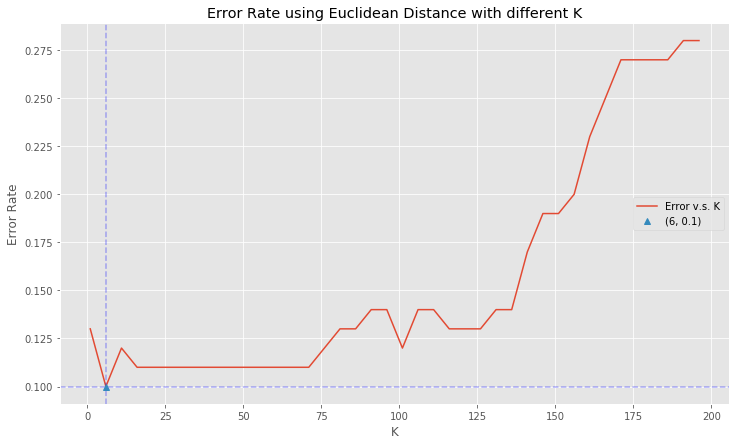

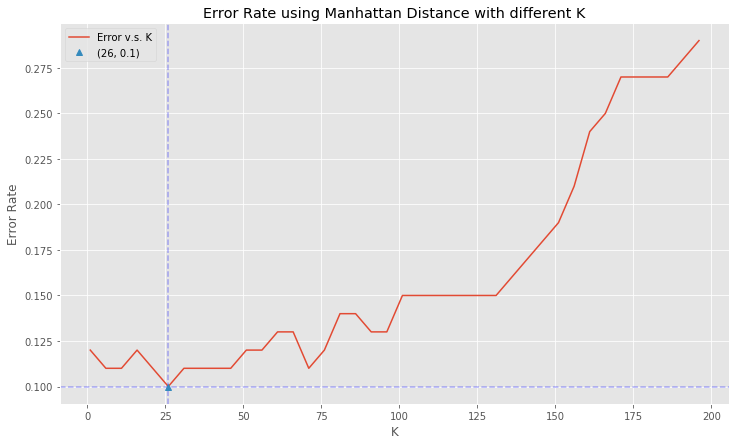

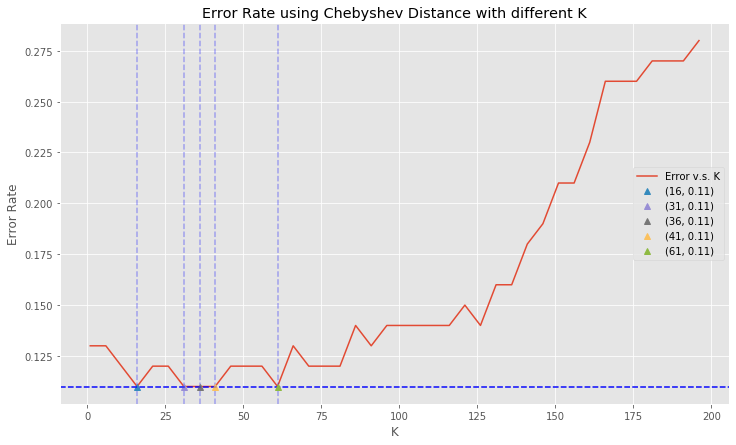

In [25]:
weighted_polling_summary = {
    'Index' : ['Optimal K', 'Error Rate'],
}

for metric in ['euclidean', 'manhattan', 'chebyshev']:
    plot_error_k(error_series[metric], k_values, best_perform[metric], metric.capitalize())
    weighted_polling_summary[metric.capitalize()] = [[res['k'] for res in best_perform[metric]], 
                                                     best_perform[metric][0]['error_rate']]

In [26]:
# summray the optimal K and error rate
weighted_polling_summary = pd.DataFrame(weighted_polling_summary)
weighted_polling_summary.set_index('Index')
weighted_polling_summary

,Index,Euclidean,Manhattan,Chebyshev
0,Optimal K,[6],[26],"[16, 31, 36, 41, 61]"
1,Error Rate,0.1,0.1,0.11


## 1.(f) The lowest training error rate you achieved in this homework

Ans: The lowest error is 0.0 for training data when $k=1$. In this case, when classifying a sample from traning set, the only neighbor is itself. Thus, the classification will be always correct.